# Spotify Music Recommendation System

In [1]:
import os
import numpy as np
import pandas as pd
import re 
import json 
import sys
import itertools
from pprint import pprint


from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt


import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
from spotipy.oauth2 import SpotifyOAuth
import spotipy.util as util
import seaborn as sns
import plotly.express as px 
import matplotlib.pyplot as plt
import sys
%matplotlib inline

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.metrics import euclidean_distances
from scipy.spatial.distance import cdist
from sklearn.linear_model import RidgeCV, LassoCV, Ridge, Lasso

import warnings
warnings.filterwarnings("ignore")

In [2]:
data_path = 'data/data.csv'
data = pd.read_csv(data_path)
data.head(3)


,Unnamed: 0,Unnamed: 0.1,pos,artist_name,track_uri,artist_uri,track_name,album_uri,duration_ms_x,album_name,...,type,id,uri,track_href,analysis_url,duration_ms_y,time_signature,artist_pop,genres,track_pop
0,0,0,0,Missy Elliott,0UaMYEvWZi0ZqiDOoHU3YI,spotify:artist:2wIVse2owClT7go1WT98tk,Lose Control (feat. Ciara & Fat Man Scoop),spotify:album:6vV5UrXcfyQD1wu4Qo2I9K,226863,The Cookbook,...,audio_features,0UaMYEvWZi0ZqiDOoHU3YI,spotify:track:0UaMYEvWZi0ZqiDOoHU3YI,https://api.spotify.com/v1/tracks/0UaMYEvWZi0Z...,https://api.spotify.com/v1/audio-analysis/0UaM...,226864,4,74,dance_pop hip_hop hip_pop pop pop_rap r&b rap ...,69
1,1,7734,73,Missy Elliott,0UaMYEvWZi0ZqiDOoHU3YI,spotify:artist:2wIVse2owClT7go1WT98tk,Lose Control (feat. Ciara & Fat Man Scoop),spotify:album:6vV5UrXcfyQD1wu4Qo2I9K,226863,The Cookbook,...,audio_features,0UaMYEvWZi0ZqiDOoHU3YI,spotify:track:0UaMYEvWZi0ZqiDOoHU3YI,https://api.spotify.com/v1/tracks/0UaMYEvWZi0Z...,https://api.spotify.com/v1/audio-analysis/0UaM...,226864,4,74,dance_pop hip_hop hip_pop pop pop_rap r&b rap ...,69
2,2,14037,14,Missy Elliott,0UaMYEvWZi0ZqiDOoHU3YI,spotify:artist:2wIVse2owClT7go1WT98tk,Lose Control (feat. Ciara & Fat Man Scoop),spotify:album:6vV5UrXcfyQD1wu4Qo2I9K,226863,The Cookbook,...,audio_features,0UaMYEvWZi0ZqiDOoHU3YI,spotify:track:0UaMYEvWZi0ZqiDOoHU3YI,https://api.spotify.com/v1/tracks/0UaMYEvWZi0Z...,https://api.spotify.com/v1/audio-analysis/0UaM...,226864,4,74,dance_pop hip_hop hip_pop pop pop_rap r&b rap ...,69


In [3]:
data.dtypes

Unnamed: 0            int64
Unnamed: 0.1          int64
pos                   int64
artist_name          object
track_uri            object
artist_uri           object
track_name           object
album_uri            object
duration_ms_x         int64
album_name           object
name                 object
danceability        float64
energy              float64
key                   int64
loudness            float64
mode                  int64
speechiness         float64
acousticness        float64
instrumentalness    float64
liveness            float64
valence             float64
tempo               float64
type                 object
id                   object
uri                  object
track_href           object
analysis_url         object
duration_ms_y         int64
time_signature        int64
artist_pop            int64
genres               object
track_pop             int64
dtype: object

In [4]:
client_id = '4379e8dc929f4f3d8b296962fb549d56'
client_secret= '08a15f73be3742f18227aec6fb9e61b4'
scope = 'user-library-read'

if len(sys.argv) > 1:
    username = sys.argv[1]
else:
    print("Usage: %s username" % (sys.argv[0],))
    sys.exit()
        
auth_manager = SpotifyClientCredentials(client_id=client_id, client_secret=client_secret)
sp = spotipy.Spotify(auth_manager=auth_manager)
token = util.prompt_for_user_token(scope, client_id= client_id, client_secret=client_secret, redirect_uri='https://mysongrecommender/dashboard/')
sp = spotipy.Spotify(auth=token)

In [34]:
id_name = {}
list_photo = {}
for i in sp.current_user_playlists()['items']:

    id_name[i['name']] = i['uri'].split(':')[2]
    list_photo[i['uri'].split(':')[2]] = i['images'][0]['url']
id_name

{'Feel good songs': '20R375waLb0fRUriQYL1iO',
 'Jogging track': '4c9aOsOYUpjS97XfEmm1l6',
 'Wilson’s Heart': '3BMq2SGR78Ptn4Yz7Jo3mK',
 'Infinity': '2ZwiIjZseXPSXpo2w1VpQZ',
 'The Winds of Winter': '29c9hEgN75p70uCN6cBwZ3',
 'Nevermind': '0LN1MMEHaowE5Dk9LtOFL7',
 'Days gone bye': '4EdpwLLnhlg4qhZJiHxZ7F'}

In [59]:
def create_necessary_outputs(playlist_name,id_dic, df):
    """ 
    Pull songs from a specific playlist.

    Parameters: 
        playlist_name (str): name of the playlist you'd like to pull from the spotify API
        id_dic (dic): dictionary that maps playlist_name to playlist_id
        df (pandas dataframe): spotify datafram
        
    Returns: 
        playlist: all songs in the playlist THAT ARE AVAILABLE IN THE KAGGLE DATASET
    """
    
    #generate playlist dataframe
    playlist = pd.DataFrame()
    playlist_name = playlist_name

    for ix, i in enumerate(sp.playlist(id_dic[playlist_name])['tracks']['items']):
        #print(i['track']['artists'][0]['name'])
        playlist.loc[ix, 'artist'] = i['track']['artists'][0]['name']
        playlist.loc[ix, 'track_name'] = i['track']['name']
        playlist.loc[ix, 'id'] = i['track']['id'] # ['uri'].split(':')[2]
        playlist.loc[ix, 'url'] = i['track']['album']['images'][1]['url']
        playlist.loc[ix, 'date_added'] = i['added_at']

    playlist['date_added'] = pd.to_datetime(playlist['date_added'])  
    
    playlist = playlist[playlist['id'].isin(df['id'].values)].sort_values('date_added',ascending = False)
    
    return playlist

In [60]:
MyPlaylist = create_necessary_outputs('Jogging track', id_name,unique_songs)

In [61]:
from skimage import io
import matplotlib.pyplot as plt

def visualize_songs(df):
    """ 
    Visualize cover art of the songs in the inputted dataframe

    Parameters: 
        df (pandas dataframe): Playlist Dataframe
    """
    
    temp = df['url'].values
    plt.figure(figsize=(15,int(0.625 * len(temp))))
    columns = 5
    
    for i, url in enumerate(temp):
        plt.subplot(len(temp) / columns + 1, columns, i + 1)

        image = io.imread(url)
        plt.imshow(image)
        plt.xticks(color = 'w', fontsize = 0.1)
        plt.yticks(color = 'w', fontsize = 0.1)
        plt.xlabel(df['track_name'].values[i], fontsize = 10)
        plt.tight_layout(h_pad=0.4, w_pad=0)
        plt.subplots_adjust(wspace=None, hspace=None)

    plt.show()

In [62]:
MyPlaylist

,artist,track_name,id,url,date_added
65,Eminem,The Real Slim Shady,3yfqSUWxFvZELEM4PmlwIR,https://i.scdn.co/image/ab67616d00001e02dbb3dd...,2021-08-11 12:20:04+00:00
49,AC/DC,Highway to Hell,2zYzyRzz6pRmhPzyfMEC8s,https://i.scdn.co/image/ab67616d00001e0251c02a...,2021-05-23 20:58:40+00:00
48,Avicii,The Nights,0ct6r3EGTcMLPtrXHDvVjc,https://i.scdn.co/image/ab67616d00001e020ae4f4...,2021-05-23 20:53:24+00:00
46,Gavin DeGraw,I Don't Want to Be,1ccNXmmgYnajJ8ulYYEK9Y,https://i.scdn.co/image/ab67616d00001e020fd30a...,2021-05-23 20:52:56+00:00
31,Scorpions,Rock You Like A Hurricane,0XIvZ82aDF7JiSi3ZE320u,https://i.scdn.co/image/ab67616d00001e02ac6c2c...,2021-05-23 20:51:58+00:00
30,Twisted Sister,We're Not Gonna Take It,1hlveB9M6ijHZRbzZ2teyh,https://i.scdn.co/image/ab67616d00001e023469ef...,2021-05-23 20:51:54+00:00
27,Gym Class Heroes,Stereo Hearts (feat. Adam Levine),0qOnSQQF0yzuPWsXrQ9paz,https://i.scdn.co/image/ab67616d00001e0218b808...,2021-05-23 20:51:27+00:00
26,Thomas Bergersen,For the Win,34x22hY9CKf3ZoPjQwZSgc,https://i.scdn.co/image/ab67616d00001e024784c4...,2021-05-23 20:51:24+00:00
22,Linkin Park,In the End,60a0Rd6pjrkxjPbaKzXjfq,https://i.scdn.co/image/ab67616d00001e02e2f039...,2021-05-23 20:51:18+00:00
17,AC/DC,Back In Black,08mG3Y1vljYA6bvDt4Wqkj,https://i.scdn.co/image/ab67616d00001e020b51f8...,2021-05-23 20:50:47+00:00


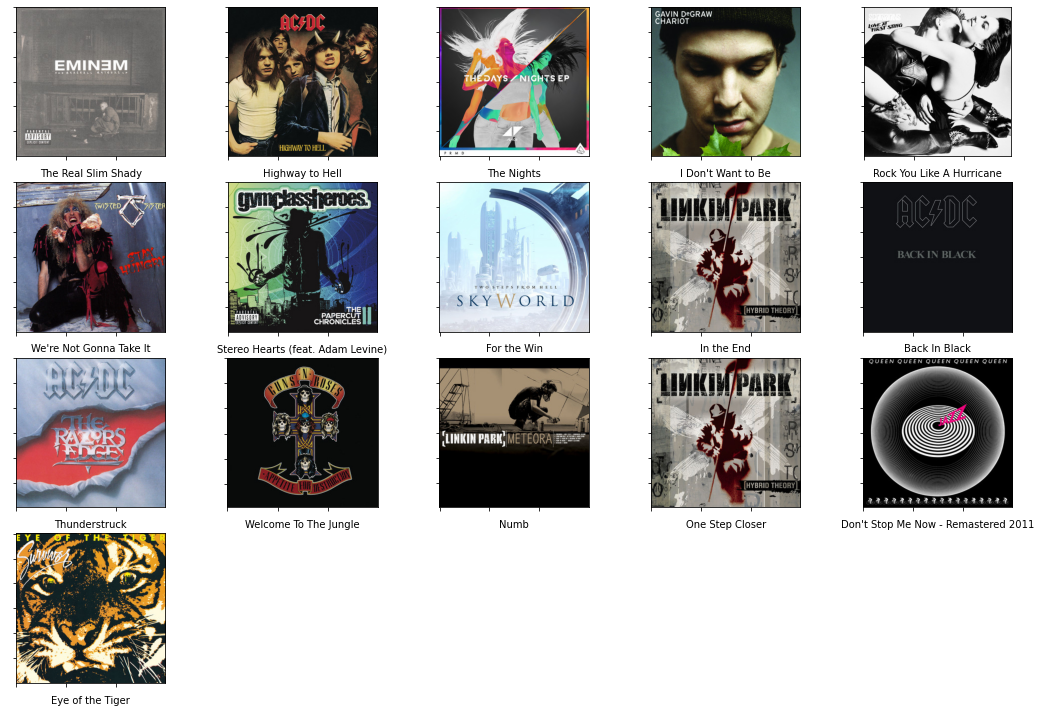

In [63]:
visualize_songs(MyPlaylist)

In [55]:
len(data)

67499

[Text(0.5, 0, 'pos'),
 Text(1.5, 0, 'duration_ms_x'),
 Text(2.5, 0, 'danceability'),
 Text(3.5, 0, 'energy'),
 Text(4.5, 0, 'loudness'),
 Text(5.5, 0, 'speechiness'),
 Text(6.5, 0, 'acousticness'),
 Text(7.5, 0, 'instrumentalness'),
 Text(8.5, 0, 'liveness'),
 Text(9.5, 0, 'valence'),
 Text(10.5, 0, 'tempo'),
 Text(11.5, 0, 'duration_ms_y'),
 Text(12.5, 0, 'time_signature'),
 Text(13.5, 0, 'artist_pop'),
 Text(14.5, 0, 'track_pop')]

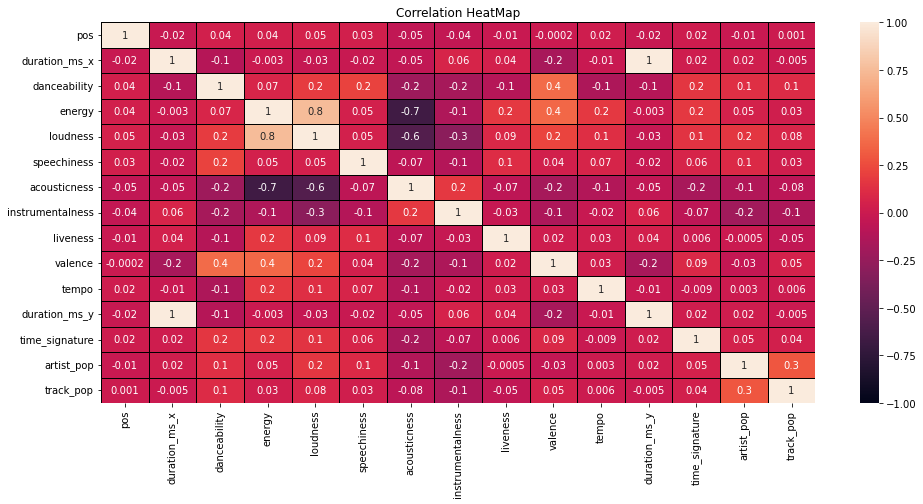

In [6]:
corr_df=data.drop(["key","mode","Unnamed: 0","Unnamed: 0.1"],axis=1).corr(method="pearson")
plt.figure(figsize=(16,7))
heatmap=sns.heatmap(corr_df,annot=True,fmt=".1g", vmin=-1, vmax=1, center=0, cmap="rocket", linewidths=1, linecolor="Black")
heatmap.set_title("Correlation HeatMap")
heatmap.set_xticklabels(heatmap.get_xticklabels(), rotation=90)

[Text(0.5, 1.0, 'Track Popularity vs Acousticness Correlation')]

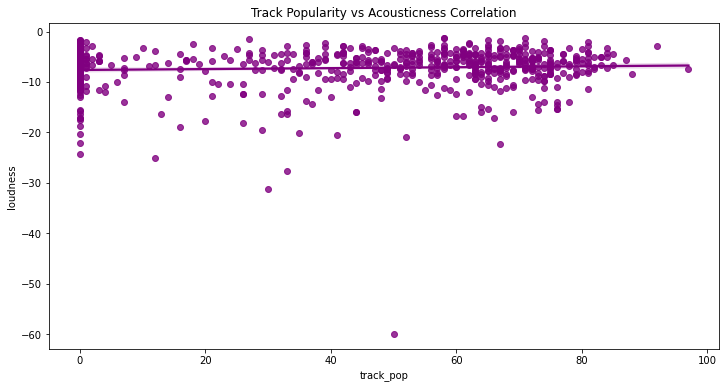

In [7]:
sample_data=data.sample(int(0.01*len(data)))
plt.figure(figsize=(12,6))
sns.regplot(data=sample_data, y="loudness", x="track_pop",color="purple").set(title="Track Popularity vs Acousticness Correlation")

[Text(0.5, 1.0, 'Popularity vs Energy Correlation')]

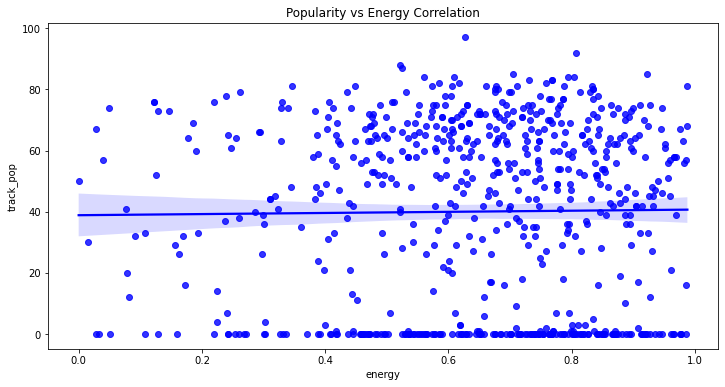

In [8]:
plt.figure(figsize=(12,6))
sns.regplot(data=sample_data, y="track_pop", x="energy",color="blue").set(title="Popularity vs Energy Correlation")

In [9]:
data[['artist_name','track_name','name']]

,artist_name,track_name,name
0,Missy Elliott,Lose Control (feat. Ciara & Fat Man Scoop),Throwbacks
1,Missy Elliott,Lose Control (feat. Ciara & Fat Man Scoop),w o r k o u t
2,Missy Elliott,Lose Control (feat. Ciara & Fat Man Scoop),party playlist
3,Missy Elliott,Lose Control (feat. Ciara & Fat Man Scoop),Dance mix
4,Missy Elliott,Lose Control (feat. Ciara & Fat Man Scoop),spin
...,...,...,...
67494,Jon D,I Don't Know,thinking of you
67495,Big Words,The Answer,thinking of you
67496,Allan Rayman,25.22,thinking of you
67497,Jon Jason,Good Feeling,thinking of you


In [10]:
def drop_duplicates(df):
    '''
    Drop duplicate songs
    '''
    df['artists_song'] = df.apply(lambda row: row['artist_name']+row['track_name'],axis = 1)
    return df.drop_duplicates('artists_song')

unique_songs = drop_duplicates(data)
print("Are all songs unique: ",len(pd.unique(unique_songs.artists_song))==len(unique_songs))

Are all songs unique:  True


In [11]:
def select_cols(df):
       '''
       Select useful columns
       '''
       return df[['artist_name','id','track_name','danceability', 'energy', 'key', 'loudness', 'mode',
       'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', "artist_pop", "genres", "track_pop"]]
unique_songs = select_cols(unique_songs)
unique_songs.head()

,artist_name,id,track_name,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,artist_pop,genres,track_pop
0,Missy Elliott,0UaMYEvWZi0ZqiDOoHU3YI,Lose Control (feat. Ciara & Fat Man Scoop),0.904,0.813,4,-7.105,0,0.1210,0.03110,0.006970,0.0471,0.810,125.461,74,dance_pop hip_hop hip_pop pop pop_rap r&b rap ...,69
6,Britney Spears,6I9VzXrHxO9rA9A5euc8Ak,Toxic,0.774,0.838,5,-3.914,0,0.1140,0.02490,0.025000,0.2420,0.924,143.040,84,dance_pop pop post-teen_pop,83
19,Beyoncé,0WqIKmW4BTrj3eJFmnCKMv,Crazy In Love,0.664,0.758,2,-6.583,0,0.2100,0.00238,0.000000,0.0598,0.701,99.259,86,dance_pop pop r&b,25
46,Justin Timberlake,1AWQoqb9bSvzTjaLralEkT,Rock Your Body,0.892,0.714,4,-6.055,0,0.1410,0.20100,0.000234,0.0521,0.817,100.972,82,dance_pop pop,79
55,Shaggy,1lzr43nnXAijIGYnCT8M8H,It Wasn't Me,0.853,0.606,0,-4.596,1,0.0713,0.05610,0.000000,0.3130,0.654,94.759,75,pop_rap reggae_fusion,2


In [12]:
def genre_preprocess(df):
    '''
    Preprocess the genre data
    '''
    df['genres_list'] = df['genres'].apply(lambda x: x.split(" "))
    return df
unique_songs = genre_preprocess(unique_songs)
unique_songs['genres_list'].head()

0     [dance_pop, hip_hop, hip_pop, pop, pop_rap, r&...
6                       [dance_pop, pop, post-teen_pop]
19                                [dance_pop, pop, r&b]
46                                     [dance_pop, pop]
55                             [pop_rap, reggae_fusion]
Name: genres_list, dtype: object

In [13]:
def playlist_preprocess(df):
    '''
    Preprocess imported playlist
    '''
    df = drop_duplicates(df)
    df = select_cols(df)
    df = genre_preprocess(df)

    return df

In [14]:
!pip install textblob
from textblob import TextBlob

def getSubjectivity(text):
  '''
  Getting the Subjectivity using TextBlob
  '''
  return TextBlob(text).sentiment.subjectivity

def getPolarity(text):
  '''
  Getting the Polarity using TextBlob
  '''
  return TextBlob(text).sentiment.polarity

def getAnalysis(score, task="polarity"):
  '''
  Categorizing the Polarity & Subjectivity score
  '''
  if task == "subjectivity":
    if score < 1/3:
      return "low"
    elif score > 1/3:
      return "high"
    else:
      return "medium"
  else:
    if score < 0:
      return 'Negative'
    elif score == 0:
      return 'Neutral'
    else:
      return 'Positive'

def sentiment_analysis(df, text_col):
  '''
  Perform sentiment analysis on text
  ---
  Input:
  df (pandas dataframe): Dataframe of interest
  text_col (str): column of interest
  '''
  df['subjectivity'] = df[text_col].apply(getSubjectivity).apply(lambda x: getAnalysis(x,"subjectivity"))
  df['polarity'] = df[text_col].apply(getPolarity).apply(getAnalysis)
  return df

In [15]:
sentiment = sentiment_analysis(unique_songs, "track_name")
sentiment.head()

,artist_name,id,track_name,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,artist_pop,genres,track_pop,genres_list,subjectivity,polarity
0,Missy Elliott,0UaMYEvWZi0ZqiDOoHU3YI,Lose Control (feat. Ciara & Fat Man Scoop),0.904,0.813,4,-7.105,0,0.1210,0.03110,0.006970,0.0471,0.810,125.461,74,dance_pop hip_hop hip_pop pop pop_rap r&b rap ...,69,"[dance_pop, hip_hop, hip_pop, pop, pop_rap, r&...",low,Neutral
6,Britney Spears,6I9VzXrHxO9rA9A5euc8Ak,Toxic,0.774,0.838,5,-3.914,0,0.1140,0.02490,0.025000,0.2420,0.924,143.040,84,dance_pop pop post-teen_pop,83,"[dance_pop, pop, post-teen_pop]",low,Neutral
19,Beyoncé,0WqIKmW4BTrj3eJFmnCKMv,Crazy In Love,0.664,0.758,2,-6.583,0,0.2100,0.00238,0.000000,0.0598,0.701,99.259,86,dance_pop pop r&b,25,"[dance_pop, pop, r&b]",high,Negative
46,Justin Timberlake,1AWQoqb9bSvzTjaLralEkT,Rock Your Body,0.892,0.714,4,-6.055,0,0.1410,0.20100,0.000234,0.0521,0.817,100.972,82,dance_pop pop,79,"[dance_pop, pop]",low,Neutral
55,Shaggy,1lzr43nnXAijIGYnCT8M8H,It Wasn't Me,0.853,0.606,0,-4.596,1,0.0713,0.05610,0.000000,0.3130,0.654,94.759,75,pop_rap reggae_fusion,2,"[pop_rap, reggae_fusion]",low,Neutral


In [16]:
def ohe_prep(df, column, new_name): 
    """ 
    Create One Hot Encoded features of a specific column

    Parameters: 
        df (pandas dataframe): Spotify Dataframe
        column (str): Column to be processed
        new_name (str): new column name to be used
        
    Returns: 
        tf_df: One hot encoded features 
    """
    
    tf_df = pd.get_dummies(df[column])
    feature_names = tf_df.columns
    tf_df.columns = [new_name + "|" + str(i) for i in feature_names]
    tf_df.reset_index(drop = True, inplace = True)    
    return tf_df

In [17]:
subject_ohe = ohe_prep(sentiment, 'subjectivity','subject')
subject_ohe.iloc[0]

subject|high      0
subject|low       1
subject|medium    0
Name: 0, dtype: uint8

In [18]:
tfidf = TfidfVectorizer()
tfidf_matrix =  tfidf.fit_transform(unique_songs['genres_list'].apply(lambda x: " ".join(x)))
genre_df = pd.DataFrame(tfidf_matrix.toarray())
genre_df.columns = ['genre' + "|" + i for i in tfidf.get_feature_names()]
genre_df.drop(columns='genre|unknown')
genre_df.reset_index(drop = True, inplace=True)
genre_df.iloc[0]

genre|21st_century_classical    0.0
genre|432hz                     0.0
genre|_hip_hop                  0.0
genre|_roll                     0.0
genre|a_cappella                0.0
                               ... 
genre|zambian_hip_hop           0.0
genre|zhongguo_feng             0.0
genre|zolo                      0.0
genre|zouk                      0.0
genre|zouk_riddim               0.0
Name: 0, Length: 2147, dtype: float64

In [21]:
print(unique_songs['artist_pop'].describe())

count    34247.000000
mean        61.916606
std         19.120147
min          0.000000
25%         51.000000
50%         65.000000
75%         76.000000
max        100.000000
Name: artist_pop, dtype: float64


In [23]:
pop = unique_songs[["artist_pop"]].reset_index(drop = True)
scaler = MinMaxScaler()
pop_scaled = pd.DataFrame(scaler.fit_transform(pop), columns = pop.columns)
pop_scaled.head()

,artist_pop
0,0.74
1,0.84
2,0.86
3,0.82
4,0.75


In [24]:
def create_feature_set(df, float_cols):
    '''
    Process spotify df to create a final set of features that will be used to generate recommendations
    ---
    Input: 
    df (pandas dataframe): Spotify Dataframe
    float_cols (list(str)): List of float columns that will be scaled
            
    Output: 
    final (pandas dataframe): Final set of features 
    '''
    
    # Tfidf genre lists
    tfidf = TfidfVectorizer()
    tfidf_matrix =  tfidf.fit_transform(df['genres_list'].apply(lambda x: " ".join(x)))
    genre_df = pd.DataFrame(tfidf_matrix.toarray())
    genre_df.columns = ['genre' + "|" + i for i in tfidf.get_feature_names()]
    genre_df.drop(columns='genre|unknown') # drop unknown genre
    genre_df.reset_index(drop = True, inplace=True)
    
    # Sentiment analysis
    df = sentiment_analysis(df, "track_name")

    # One-hot Encoding
    subject_ohe = ohe_prep(df, 'subjectivity','subject') * 0.3
    polar_ohe = ohe_prep(df, 'polarity','polar') * 0.5
    key_ohe = ohe_prep(df, 'key','key') * 0.5
    mode_ohe = ohe_prep(df, 'mode','mode') * 0.5

    # Normalization
    # Scale popularity columns
    pop = df[["artist_pop","track_pop"]].reset_index(drop = True)
    scaler = MinMaxScaler()
    pop_scaled = pd.DataFrame(scaler.fit_transform(pop), columns = pop.columns) * 0.2 

    # Scale audio columns
    floats = df[float_cols].reset_index(drop = True)
    scaler = MinMaxScaler()
    floats_scaled = pd.DataFrame(scaler.fit_transform(floats), columns = floats.columns) * 0.2

    # Concanenate all features
    final = pd.concat([genre_df, floats_scaled, pop_scaled, subject_ohe, polar_ohe, key_ohe, mode_ohe], axis = 1)
    
    # Add song id
    final['id']=df['id'].values
    
    return final

In [27]:
float_cols = unique_songs.dtypes[unique_songs.dtypes == 'float64'].index.values
unique_songs.to_csv("data/data.csv", index = False)

# Generate features
complete_feature_set = create_feature_set(unique_songs, float_cols=float_cols)
complete_feature_set.to_csv("data/complete_feature.csv", index = False)
complete_feature_set.head()

,genre|21st_century_classical,genre|432hz,genre|_hip_hop,genre|_roll,genre|a_cappella,genre|abstract_beats,genre|abstract_hip_hop,genre|accordion,genre|acid_jazz,genre|acid_rock,...,key|5,key|6,key|7,key|8,key|9,key|10,key|11,mode|0,mode|1,id
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0UaMYEvWZi0ZqiDOoHU3YI
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.0,6I9VzXrHxO9rA9A5euc8Ak
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0WqIKmW4BTrj3eJFmnCKMv
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.0,1AWQoqb9bSvzTjaLralEkT
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,1lzr43nnXAijIGYnCT8M8H


In [31]:
def generate_playlist_feature(complete_feature_set, playlist_df, weight_factor):
    """ 
    Summarize a user's playlist into a single vector

    Parameters: 
        complete_feature_set (pandas dataframe): Dataframe which includes all of the features for the spotify songs
        playlist_df (pandas dataframe): playlist dataframe
        weight_factor (float): float value that represents the recency bias. The larger the recency bias, the most priority recent songs get. Value should be close to 1. 
        
    Returns: 
        playlist_feature_set_weighted_final (pandas series): single feature that summarizes the playlist
        complete_feature_set_nonplaylist (pandas dataframe): 
    """
    
    complete_feature_set_playlist = complete_feature_set[complete_feature_set['id'].isin(playlist_df['id'].values)]#.drop('id', axis = 1).mean(axis =0)
    complete_feature_set_playlist = complete_feature_set_playlist.merge(playlist_df[['id','date_added']], on = 'id', how = 'inner')
    complete_feature_set_nonplaylist = complete_feature_set[~complete_feature_set['id'].isin(playlist_df['id'].values)]#.drop('id', axis = 1)
    
    playlist_feature_set = complete_feature_set_playlist.sort_values('date_added',ascending=False)

    most_recent_date = playlist_feature_set.iloc[0,-1]
    
    for ix, row in playlist_feature_set.iterrows():
        playlist_feature_set.loc[ix,'months_from_recent'] = int((most_recent_date.to_pydatetime() - row.iloc[-1].to_pydatetime()).days / 30)
        
    playlist_feature_set['weight'] = playlist_feature_set['months_from_recent'].apply(lambda x: weight_factor ** (-x))
    
    playlist_feature_set_weighted = playlist_feature_set.copy()
    #print(playlist_feature_set_weighted.iloc[:,:-4].columns)
    playlist_feature_set_weighted.update(playlist_feature_set_weighted.iloc[:,:-4].mul(playlist_feature_set_weighted.weight,0))
    playlist_feature_set_weighted_final = playlist_feature_set_weighted.iloc[:, :-4]
    #playlist_feature_set_weighted_final['id'] = playlist_feature_set['id']
    
    return playlist_feature_set_weighted_final.sum(axis = 0), complete_feature_set_nonplaylist

In [45]:
complete_feature_set_playlist_vector_EDM, complete_feature_set_nonplaylist_EDM = generate_playlist_feature(complete_feature_set, MyPlaylist, 1.09)


In [46]:
complete_feature_set_playlist_vector_EDM.shape

(2178,)

In [47]:
def generate_playlist_recos(df, features, nonplaylist_features):
    """ 
    Pull songs from a specific playlist.

    Parameters: 
        df (pandas dataframe): spotify dataframe
        features (pandas series): summarized playlist feature
        nonplaylist_features (pandas dataframe): feature set of songs that are not in the selected playlist
        
    Returns: 
        non_playlist_df_top_40: Top 40 recommendations for that playlist
    """
    
    non_playlist_df = df[df['id'].isin(nonplaylist_features['id'].values)]
    non_playlist_df['sim'] = cosine_similarity(nonplaylist_features.drop('id', axis = 1).values, features.values.reshape(1, -1))[:,0]
    non_playlist_df_top_40 = non_playlist_df.sort_values('sim',ascending = False).head(40)
    non_playlist_df_top_40['url'] = non_playlist_df_top_40['id'].apply(lambda x: sp.track(x)['album']['images'][1]['url'])
    
    return non_playlist_df_top_40

In [49]:
reco_top40 = generate_playlist_recos(unique_songs, complete_feature_set_playlist_vector_EDM, complete_feature_set_nonplaylist_EDM)

In [50]:
reco_top40

,artist_name,id,track_name,danceability,energy,key,loudness,mode,speechiness,acousticness,...,valence,tempo,artist_pop,genres,track_pop,genres_list,subjectivity,polarity,sim,url
24564,AC/DC,7LRMbd3LEoV5wZJvXT1Lwb,T.N.T.,0.754,0.759,9,-5.218,1,0.3020,0.153000,...,0.435,126.366,84,australian_rock hard_rock rock,79,"[australian_rock, hard_rock, rock]",low,Neutral,0.761730,https://i.scdn.co/image/ab67616d00001e02286a08...
58992,AC/DC,6Th6ND8RQPywiyelecP5Lf,What Do You Do for Money Honey,0.532,0.858,9,-5.023,1,0.0599,0.005330,...,0.495,125.698,84,australian_rock hard_rock rock,62,"[australian_rock, hard_rock, rock]",low,Neutral,0.760339,https://i.scdn.co/image/ab67616d00001e020b51f8...
58997,AC/DC,6J17MkMmuzBiIOjRH6MOBZ,Rock and Roll Ain't Noise Pollution,0.576,0.659,9,-5.617,1,0.0383,0.041000,...,0.717,94.853,84,australian_rock hard_rock rock,64,"[australian_rock, hard_rock, rock]",low,Neutral,0.756972,https://i.scdn.co/image/ab67616d00001e020b51f8...
56793,AC/DC,17lu4tymfnhmcIDlzBbtAb,For Those About to Rock (We Salute You),0.370,0.919,4,-5.721,1,0.1020,0.000376,...,0.471,134.021,84,australian_rock hard_rock rock,67,"[australian_rock, hard_rock, rock]",low,Neutral,0.733767,https://i.scdn.co/image/ab67616d00001e020d0253...
59001,Alice In Chains,4A065x9kJt955eGVqf813g,Them Bones,0.159,0.946,9,-5.756,1,0.0629,0.023500,...,0.309,165.014,73,alternative_metal alternative_rock classic_roc...,69,"[alternative_metal, alternative_rock, classic_...",low,Neutral,0.726260,https://i.scdn.co/image/ab67616d00001e021cd131...
43724,Led Zeppelin,4PRGxHpCpF2yoOHYKQIEwD,Rock And Roll,0.317,0.887,9,-7.292,1,0.0375,0.000582,...,0.871,169.613,80,album_rock classic_rock hard_rock rock,72,"[album_rock, classic_rock, hard_rock, rock]",low,Neutral,0.724601,https://i.scdn.co/image/ab67616d00001e02c8a11e...
46796,Stone Temple Pilots,2nWjhmRImt6LScZIPQMBnM,Sex Type Thing,0.397,0.969,9,-3.892,1,0.0463,0.000002,...,0.702,134.288,69,alternative_metal alternative_rock grunge hard...,56,"[alternative_metal, alternative_rock, grunge, ...",low,Neutral,0.722419,https://i.scdn.co/image/ab67616d00001e02171f7a...
36388,AC/DC,5u5F7qLDvZjBSktaDp4HxB,Moneytalks,0.649,0.903,7,-3.677,1,0.0318,0.000841,...,0.412,121.841,84,australian_rock hard_rock rock,66,"[australian_rock, hard_rock, rock]",low,Neutral,0.721281,https://i.scdn.co/image/ab67616d00001e02839904...
59022,AC/DC,2vyae4DvSU2gs8OMOGwXF2,Rock or Bust,0.572,0.825,8,-3.977,1,0.0400,0.000071,...,0.560,98.057,84,australian_rock hard_rock rock,64,"[australian_rock, hard_rock, rock]",low,Neutral,0.719371,https://i.scdn.co/image/ab67616d00001e02f5ea32...
43690,Led Zeppelin,3MODES4TNtygekLl146Dxd,Ramble On,0.468,0.607,9,-11.367,1,0.0336,0.072000,...,0.886,98.429,80,album_rock classic_rock hard_rock rock,72,"[album_rock, classic_rock, hard_rock, rock]",low,Neutral,0.718085,https://i.scdn.co/image/ab67616d00001e02fc4f17...


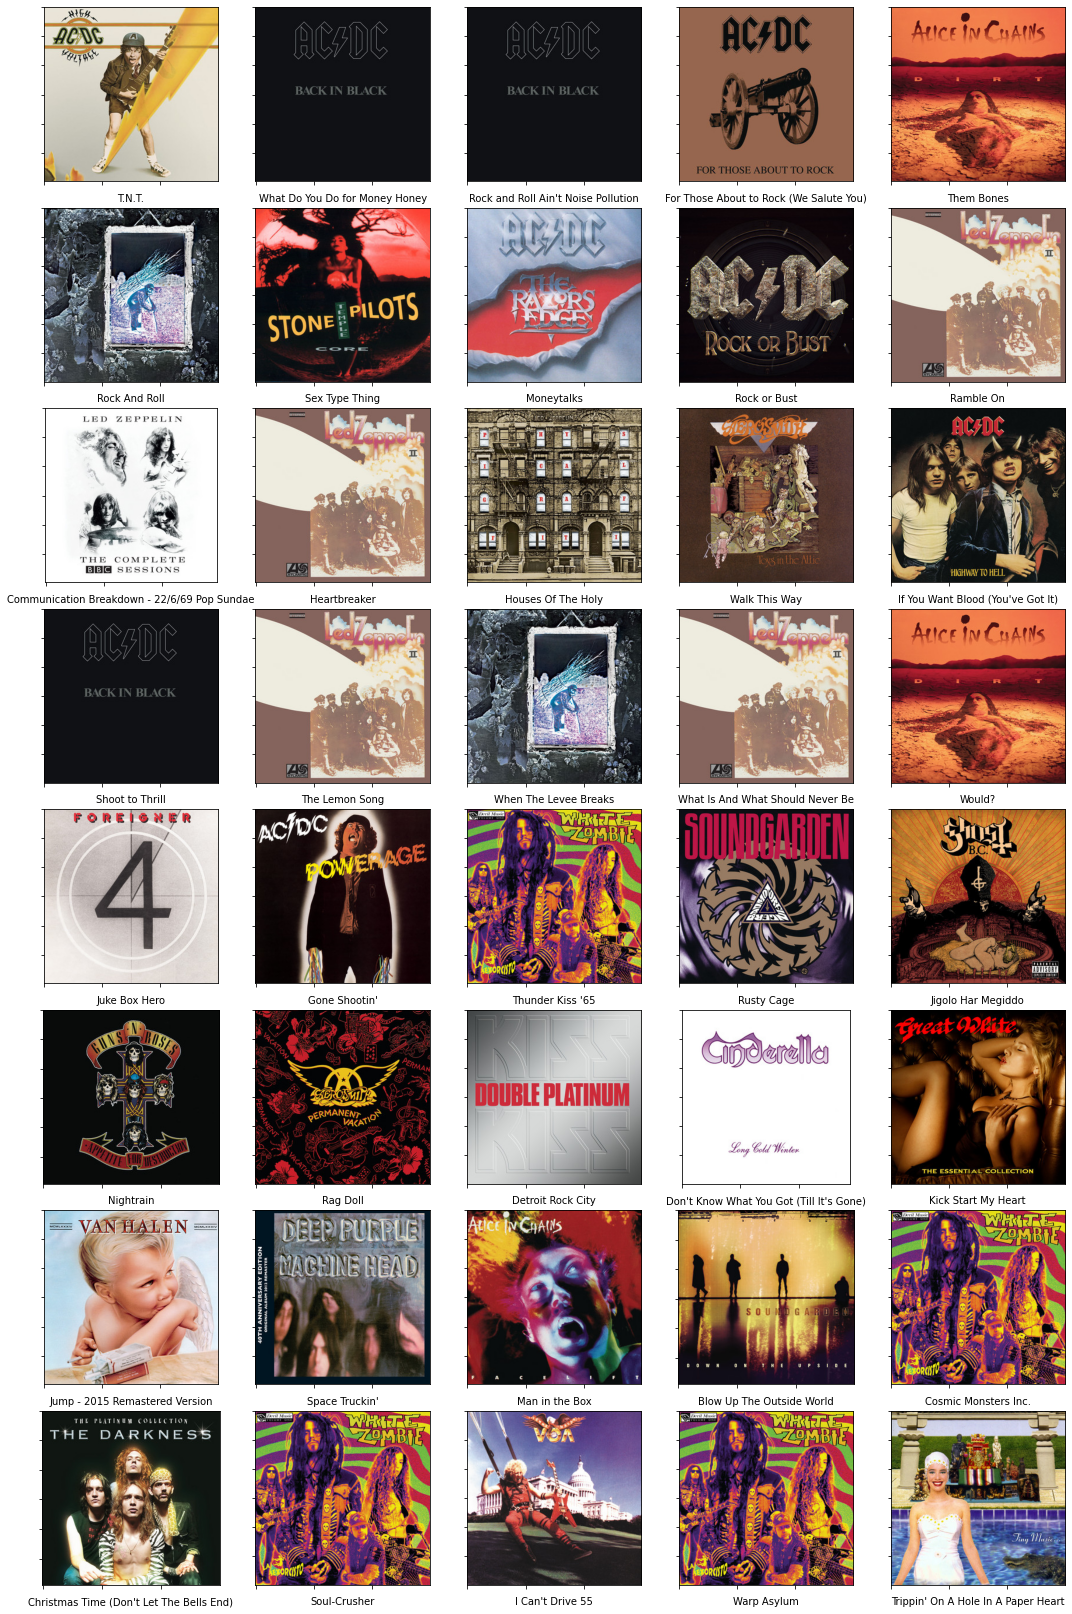

In [64]:
visualize_songs(reco_top40)

------End of Project-----